In [15]:
#import packages

import pandas as pd
import twint
import nest_asyncio

nest_asyncio.apply()
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
import re
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import textblob
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import pyLDAvis.gensim
import gensim.corpora as corpora
import pyLDAvis

import gensim



## Get Tweet Data

Before we start to analyize the data, we need a collection of tweets. So let's use Twint to scrape Twitter for all tweets that mention Billie Eilish. She will be our pilot subject that we'll use to gather data on so that we can start getting insights on her audience. Let's gather all tweets from the last year with 'billie eilish' as our search keyword.

In [68]:
#function take in 3 inputs: username, number of tweets, and since date as inputs and saves as a csv file
def get_tweets_by_user(username, limit, since_date):
    c = twint.Config()
    c.Username = username
    c.Limit = limit
    c.Since = since_date
    c.Format = "Tweet ID: {id} | Date: {date} | Username: {username} | Tweet: {tweet} | #Replies: {replies} | #Retweets: {retweets} | #Likes: {likes}"
    c.Store_csv = True
    c.Hide_output = True
    c.Output = 'usertweetdata.csv'
    twint.run.Search(c)  
    
get_tweets_by_user('realDonaldTrump', 1000, '2020-03-04')

## Data Cleaning

In [39]:
#lets read in the dataframe

df = pd.read_csv('usertweetdata.csv')


In [40]:
#how many tweets did we get?
df.shape

(935, 34)

In [41]:
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1260595662091100161,1260595662091100161,1589384401000,2020-05-13,11:40:01,Eastern Daylight Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
1,1260578860992737285,1260578860992737285,1589380395000,2020-05-13,10:33:15,Eastern Daylight Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
2,1260574760930545666,1260574760930545666,1589379418000,2020-05-13,10:16:58,Eastern Daylight Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
3,1260562505845354497,1260562505845354497,1589376496000,2020-05-13,09:28:16,Eastern Daylight Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
4,1260561967573602321,1260561967573602321,1589376367000,2020-05-13,09:26:07,Eastern Daylight Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,1235014340077473792,1235014340077473792,1583285338000,2020-03-03,20:28:58,Eastern Daylight Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
931,1235013938150092800,1235013938150092800,1583285242000,2020-03-03,20:27:22,Eastern Daylight Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
932,1235013832105431040,1235013832105431040,1583285217000,2020-03-03,20:26:57,Eastern Daylight Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
933,1235005879226961924,1235005879226961924,1583283321000,2020-03-03,19:55:21,Eastern Daylight Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN


### Preprocess Raw Text



In [24]:
df.tweet.head(10)

0    Singer/producer @nogaerez took some time durin...
1    We're airing live coverage of @TaylorMadeGolf'...
2    .@andersoncooper just had his first cup of cof...
3    “The Michelle Collins Show” has been honored b...
4    Members of The Jackson 5 told the story of how...
5    We're excited to share that "Bevelations" has ...
6    Once @AvrilLavigne's world tour was cancelled,...
7    We're calling on fans to decide the most essen...
8    .@FrencHMonTanA has known that he'd make it as...
9    Hear @Metallica's biggest songs, commentary fr...
Name: tweet, dtype: object

#### Remove Handles

In [8]:
#removing user handles from tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 




#### Remove URLs

In [9]:
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[/w]*")
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "http([/S]*)?")
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "pic.twitter.com(/[/w]*)?")

#### Remove Punctuations, special characters, numbers

In [10]:
# remove special characters, numbers, punctuations
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")


#### Tokenize Tweets

In [19]:
#tokenize tweets

def tokenization(text):
    text = re.split('/W+', text)
    return text

df['tokenized_tweet'] = df['tidy_tweet'].apply(lambda x: tokenization(x.lower()))
df['tokenized_tweet'].head(10)

0    [#     rez fail  when mercy tries to rez and s...
1              [this  has made my day  gracias       ]
2                   [billie eilish   khalid lovely   ]
3    [do you guys an artist that you listen to and ...
4                     [what the fuck is billie eilish]
5        [yassssssssssssssssss  good job gurl dojacat]
6    [bro billie eilish gotta eat ranch you re enti...
7                          [billieeilish marry me pls]
8                     [also how did you do that   lol]
9    [fav artists  like musicians gfdfhgh   paramor...
Name: tokenized_tweet, dtype: object

#### Remove short Words

In [11]:
# removing short words

df['tidy_tweet'] =df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

#### Lemmatize Tweets

In [12]:
#create another column where the words are lemmatized

lemmatizer = WordNetLemmatizer()

In [13]:
df['lemmatized_tweets'] = df['tidy_tweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word.lower()) for word in x.split()]))

#### Remove Stopwords

In [14]:
stop_words = list(set(stopwords.words('english')))

#adding stopwords that include search term and song titles
new_stopwords = ['gon', 'na', 'wan', 'na', 'http', 'fall', 'asleep', 'billie', 'eilish', 'billieeilish', 'all', 'the', 'good', 'girls', 'go', 'to', 'hell', 'everything', 'i', 'wanted', 'bad', 'guy', 'lovely', 
                 'ocean', 'eyes', 'when', 'over', 'no', 'time', 'to', 'die', 'bellyache', 'xanny', 'wish', 'you', 'were' 'gay']
stop_words.extend(new_stopwords)

In [15]:
non_stopword_tweets = []
for i in df['lemmatized_tweets']:
    
    word_tokens = word_tokenize(i) 
    non_stopword_tweets.append(' '.join([word for word in word_tokens if word not in stop_words]))

    
df['lemmatized_tweets'] = non_stopword_tweets

#### Sentiment Analysis

In [25]:
analyser = SentimentIntensityAnalyzer()

In [26]:
def get_tweet_sentiment(tweet):
    polarity_scores = analyser.polarity_scores(tweet)
    return polarity_scores['compound']

get_tweet_sentiment(df['tweet'][0])

-0.8225

In [27]:
df['tweet_sentiment'] = df['tweet'].apply(lambda x: get_tweet_sentiment(x))

In [28]:
df['sentiment_polarity'] = df['tweet_sentiment'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))


In [29]:
sentiment_countdf = df.groupby('sentiment_polarity')['id'].count().reset_index()
sentiment_countdf


,sentiment_polarity,id
0,negative,2868
1,neutral,4612
2,positive,7076


Text(0, 0.5, '# of Tweets')

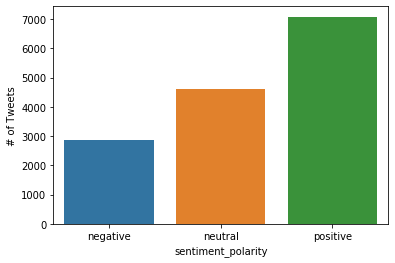

In [30]:
sns.barplot(data=sentiment_countdf, x='sentiment_polarity', y='id')
plt.ylabel('# of Tweets')

In [31]:
#create dataframes of positive and negative tweets
positive_tweets_df = df.loc[df['sentiment_polarity'] == 'positive']
negative_tweets_df = df.loc[df['sentiment_polarity'] == 'negative']

In [32]:
popular_tweets_df = df.loc[df['retweets_count'] > 50]
unpopular_tweets_df = df.loc[df['retweets_count'] < 50]

In [19]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'tweet', 'mentions', 'urls', 'photos',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'video', 'reply_to', 'tidy_tweet',
       'lemmatized_tweets'],
      dtype='object')

In [18]:
df.dropna('lemmatized_tweets', axis=0)

TypeError: dropna() got multiple values for argument 'axis'

### Save Cleaned data

In [20]:
df.to_csv('clean_billie_tweets.csv')

## EDA

In [42]:
import seaborn as sns

In [16]:
#lets read in the dataframe

df = pd.read_csv('clean_billie_tweets.csv')
df.columns

Index(['Unnamed: 0', 'id', 'conversation_id', 'created_at', 'date', 'time',
       'timezone', 'user_id', 'username', 'name', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'video', 'reply_to', 'tidy_tweet',
       'lemmatized_tweets'],
      dtype='object')

In [17]:
likes_per_day = df.groupby('date')['likes_count'].sum().reset_index()
likes_per_day

,date,likes_count
0,2020-03-30,270294
1,2020-03-31,239320
2,2020-04-01,8771
3,2020-04-03,217


### Open clean dataframe

In [22]:
clean_df = pd.read_csv('clean_billie_tweets.csv', index_col=0)
clean_df.dropna(inplace=True)

In [19]:
#let's explore the distribution of tweets by date

tweets_by_date = clean_df.groupby('date')['tweet'].count().reset_index()

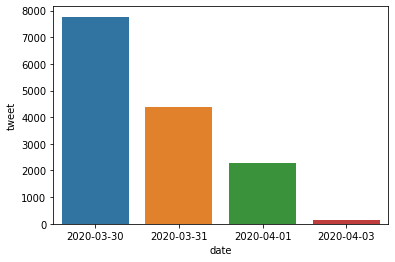

In [20]:
sns.barplot(data=tweets_by_date, x='date', y='tweet')

### Frequent Words - WordClouds

In [31]:
#let's visualize the most frequent words from the entire dataset

all_words = ' '.join([text for text in clean_df['lemmatized_tweets'] if type(text) != float])


In [32]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)


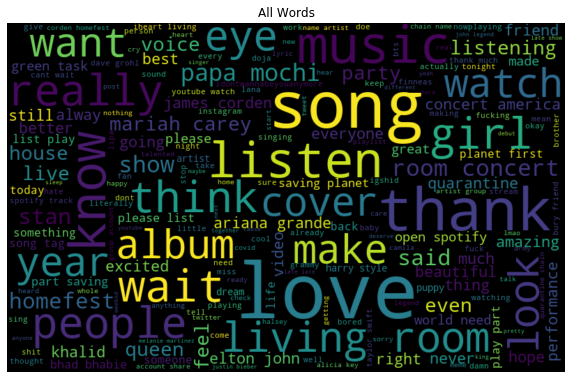

In [33]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words')
plt.show()

In [34]:
#lets look out wordclouds for each date

march30_df = clean_df[clean_df['date'] == '2020-03-30']
march31_df = clean_df[clean_df['date'] == '2020-03-31']
april1_df = clean_df[clean_df['date'] == '2020-04-01']

m30_words = ' '.join([text for text in march30_df['lemmatized_tweets'] if type(text) != float])
m30_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(m30_words)


m31_words = ' '.join([text for text in march31_df['lemmatized_tweets'] if type(text) != float])
m31_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(m31_words)


a1_words = ' '.join([text for text in april1_df['lemmatized_tweets'] if type(text) != float])
a1_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(a1_words)


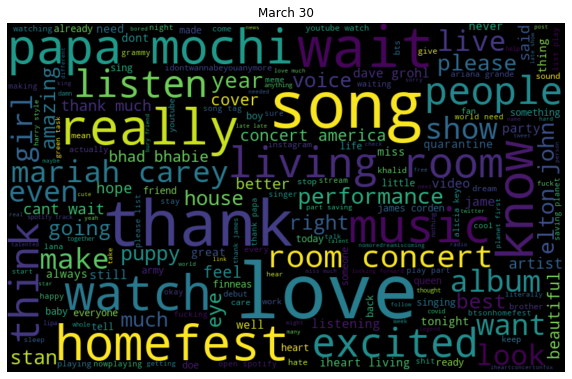

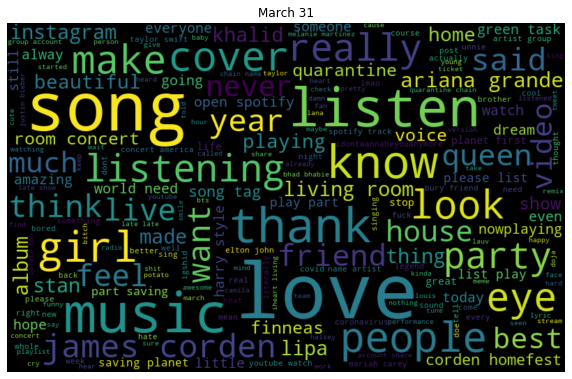

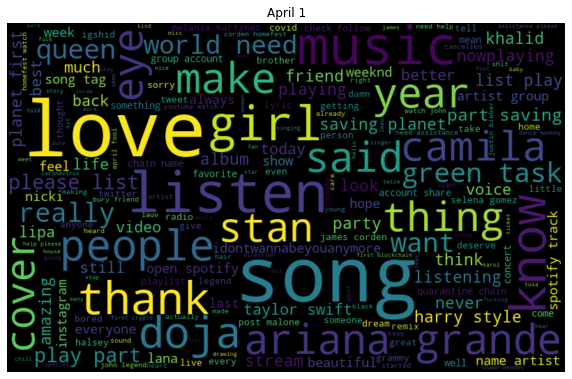

In [35]:


plt.figure(figsize=(10, 7))
plt.imshow(m30_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('March 30')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(m31_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('March 31')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(a1_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('April 1')
plt.show()

#### Most Frequent Words

In [36]:


# all_word_list = word_tokenize(all_words)
clean_df['lemmatized_tweets'].dropna(inplace=True)

In [39]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_df['lemmatized_tweets'], 50)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

like 1185
love 1144
song 1030
thank 580
music 494
watch 477
wait 466
http 457
concert 436
please 413
know 407
homefest 400
much 386
listen 375
really 369
need 363
james 350
artist 346
girl 307
would 300
people 297
show 292
play 276
na 276
home 273
year 271
look 271
think 265
make 262
room 255
live 252
friend 248
first 248
album 242
world 241
video 240
living 240
youtube 238
want 238
mochi 237
eye 232
cover 231
john 228
said 212
papa 209
thing 208
listening 197
coronavirus 197
best 196
voice 195


AttributeError: 'Series' object has no attribute 'iplot'

### Wordclouds for positive/negative tweets

In [ ]:
#let's visualize the most frequent words from the entire dataset

all_words_positive = ' '.join([text for text in positive_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_positive)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Positive Tweets')
plt.show()

In [ ]:
# common_words = get_top_n_words(positive_tweets_df['lemmatized_tweets'], 50)
# for word, freq in common_words:
#     print(word, freq)
# df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
# df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
# kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

In [ ]:
#wordcloud for negative tweets

all_words_negative = ' '.join([text for text in negative_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_negative)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Negative Tweets')
plt.show()

In [ ]:
# common_words = get_top_n_words(negative_tweets_df['lemmatized_tweets'], 50)
# for word, freq in common_words:
#     print(word, freq)
# df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
# df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
# kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

### Wordclouds for Popular/Unpopular Tweets

In [ ]:
#wordcloud for popular retweets (over 50)

all_words_popular = ' '.join([text for text in popular_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_popular)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Popular Tweets')
plt.show()

In [ ]:
#wordcloud for unpopular retweets (less than 50)

all_words_unpopular = ' '.join([text for text in unpopular_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_unpopular)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Unpopular Tweets')
plt.show()

### distribution of top unigrams after  stop words

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(popular_tweets_df['lemmatized_tweets'], 20)

# for word, freq in common_words:
#     print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])
sns.barplot(data=df2, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Words from Popular Tweets')
# df2.groupby('lemmatized_tweets').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')


In [ ]:
common_words = get_top_n_words(df['lemmatized_tweets'], 20)

# for word, freq in common_words:
#     print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])
sns.barplot(data=df2, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Words from All Tweets')

### The distribution of top bigrams after removing stop words


In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(popular_tweets_df['lemmatized_tweets'], 20)
# for word, freq in common_words:
#     print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])

sns.barplot(data=df3, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Bigrams from Popular Tweets')



In [ ]:
common_words = get_top_n_bigram(df['lemmatized_tweets'], 20)
# for word, freq in common_words:
#     print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])

sns.barplot(data=df4, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Bigrams from All Tweets')


### TF-IDF
Let's calculate the importance of each word using TF-IDF scores. This will help us decide if there are other words we should be adding to our stopword list. Using non lemmatized words.

In [369]:
#drop rows with nan values in tweets
clean_df.dropna(axis=0, subset=['lemmatized_tweets'], inplace=True)

#### Vectorize Words

In [82]:
#create function to vectorize song

def count_vectorize(tweet, vocab=None):
    tokenized_tweet = word_tokenize(tweet)
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(tokenized_tweet))
    
    tweet_dict = {i:0 for i in unique_words}
    
    for word in tokenized_tweet:
        tweet_dict[word] += 1
    
    return tweet_dict

In [83]:
BoW = count_vectorize(df['lemmatized_tweets'])

TypeError: expected string or bytes-like object

#### Term Frequency

In [84]:
#Term Frequency

#create term frequency function
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict

BoW_dict = term_frequency(wordfreq)

NameError: name 'wordfreq' is not defined

{'fail': 1.1257331337033242e-05,
 'mercy': 4.502932534813297e-05,
 'try': 3.377199401109973e-05,
 'killed': 9.005865069626594e-05,
 'play': 0.003107023449021175,
 'player': 9.005865069626594e-05,
 'team': 0.0005290945728405624,
 'made': 0.0015535117245105874,
 'gracias': 2.2514662674066484e-05,
 'khalid': 0.0019137463272956513,
 'artist': 0.003895036642613502,
 'listen': 0.0042214992513874665,
 'would': 0.003377199401109973,
 'think': 0.0029831928043138095,
 'mine': 0.00032646260877396404,
 'sheeran': 0.0002364039580776981,
 'fuck': 0.0008668145129515597,
 'yassssssssssssssssss': 1.1257331337033242e-05,
 'gurl': 2.2514662674066484e-05,
 'got': 0.00025891862075176457,
 'ta': 0.00025891862075176457,
 'ranch': 1.1257331337033242e-05,
 'entitled': 5.6286656685166215e-05,
 'marry': 0.0002138892954036316,
 'also': 0.0015872837185216873,
 'like': 0.013339937634384394,
 'musician': 0.0005966385608627619,
 'gfdfhgh': 1.1257331337033242e-05,
 'paramore': 0.00012383064470736568,
 'direction': 0.0

#### Create List of Dictionaries

In [85]:
#create a list of dictionaries
def create_list_of_BoW(tweets):

    list_of_dictionaries = []

    for tweet in tweets:
        BoW = count_vectorize(tweet)

        list_of_dictionaries.append(BoW)
    return list_of_dictionaries

list_of_dictionaries = create_list_of_BoW(df['lemmatized_tweets'])


In [154]:
#create dictionary of corpus
wordfreq = {}
for tweet in df['lemmatized_tweets']:
    tokens = nltk.word_tokenize(tweet)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

print(wordfreq)

{'fail': 1, 'mercy': 4, 'try': 3, 'killed': 8, 'play': 276, 'player': 8, 'team': 47, 'made': 138, 'gracias': 2, 'khalid': 170, 'artist': 346, 'listen': 375, 'would': 300, 'think': 265, 'mine': 29, 'sheeran': 21, 'fuck': 77, 'yassssssssssssssssss': 1, 'gurl': 2, 'got': 23, 'ta': 23, 'ranch': 1, 'entitled': 5, 'marry': 19, 'also': 141, 'like': 1185, 'musician': 53, 'gfdfhgh': 1, 'paramore': 11, 'direction': 35, 'louis': 69, 'harry': 132, 'solo': 15, 'state': 10, 'champ': 1, 'george': 3, 'michael': 24, 'waterparks': 6, 'jonas': 11, 'brother': 126, 'wonder': 33, 'looked': 20, 'pegged': 1, 'beliber': 1, 'however': 8, 'spell': 6, 'stupid': 56, 'thing': 208, 'listening': 197, 'lately': 10, 'dark': 34, 'cool': 83, 'stuff': 36, 'cross': 1, 'hope': 147, 'vibrator': 1, 'diva': 4, '#': 4530, 'nowplaying': 136, 'radio': 78, 'pritzwalk': 1, 'brandenburg': 2, 'ger': 2, 'name': 192, 'band': 58, 'mean': 128, 'people': 297, 'aries': 3, 'jakey': 1, 'peep': 17, 'donge': 1, 'markier': 1, 'current': 12, 'ha

#### Inverse Document Frequency

In [220]:
#Inverse Document Frequency
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

In [221]:
tf_idf_dict = inverse_document_frequency(list_of_dictionaries)

In [278]:

stop_word_dict = []
for k,v in (tf_idf_dict.items()):
    if tf_idf_dict[k] < 6:
        stop_word_dict.append((k,v))

print(stop_word_dict)
        

[('meet', 5.989100644178637), ('iheart', 4.535666980221118), ('famous', 5.743978186145652), ('backstreet', 5.9350334229083614), ('saving', 4.744305845332446), ('still', 4.595885840214173), ('thought', 5.141802783791433), ('getting', 5.309939705593432), ('felt', 5.478275020412647), ('probably', 5.834949964351378), ('dear', 5.909057936505101), ('kpop', 5.811419466941184), ('band', 5.529568314800197), ('seen', 5.445485197589655), ('want', 4.130201872112953), ('watch', 3.4545223845933988), ('spotify', 4.325595510474261), ('definitely', 5.961701669990522), ('march', 5.7659570928644275), ('book', 5.9350334229083614), ('pentatonix', 5.701418571726856), ('streaming', 5.640793949910421), ('doja', 5.040020089481491), ('stupid', 5.660596577206601), ('lorde', 5.909057936505101), ('person', 5.338513078037487), ('true', 5.811419466941184), ('ticket', 5.701418571726856), ('chain', 5.35311187745864), ('first', 4.07136137209002), ('troye', 5.961701669990522), ('alicia', 5.309939705593432), ('btsonhomef

In [54]:
#find min and max TF-IDF value in corpus

key_max = max(tf_idf_dict.keys(), key=(lambda k: tf_idf_dict[k]))
key_min = min(tf_idf_dict.keys(), key=(lambda k: tf_idf_dict[k]))

print('Maximum Value: ',tf_idf_dict[key_max])
print('Minimum Value: ',tf_idf_dict[key_min])

Maximum Value:  9.58293787645873
Minimum Value:  0.40843195749176353


### Modeling

#### LDA & NMF Models using TF and TFIDF

In [23]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 5000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=50, max_features=no_features, ngram_range=(2,3))
tfidf = tfidf_vectorizer.fit_transform(clean_df['lemmatized_tweets'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=50, max_features=no_features, ngram_range=(2,3))
tf = tf_vectorizer.fit_transform(clean_df['lemmatized_tweets'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [24]:
from sklearn.decomposition import NMF, LatentDirichletAllocation



# Run NMF
nmf = NMF(n_components=4, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=4, max_iter=5, learning_method='online', learning_offset=50.,random_state=0, ).fit(tf)


In [34]:
#create a function to display topic results
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))




In [37]:
#display topics from nmf model
no_top_words = 4
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
papa mochi thank much cant wait love much
Topic 1:
living room room concert living room concert iheart living room
Topic 2:
look like bhad bhabie ariana grande youtube watch
Topic 3:
open spotify open spotify track spotify track bury friend


In [38]:
#display topics from lda model
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
papa mochi dave grohl open spotify harry style
Topic 1:
living room room concert living room concert concert america
Topic 2:
cant wait love twitter name artist group like
Topic 3:
mariah carey elton john james corden look like


#### LDA Modeling with Gensim

In [43]:
import pyLDAvis.gensim
import gensim
from gensim import corpora


#### LDA Modeling with Gemsin using bigrams

In [29]:
def create_topics(processed_data, num_of_topics):
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

        
    data = processed_data.values.tolist()
    data_words = list(sent_to_words(data))

    bigrams = gensim.models.Phrases(data_words, min_count=10)
    for idx in range(len(processed_data)):
        for token in bigrams[processed_data[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                processed_data[idx].append(token)

    # Create Dictionary
    id2word = corpora.Dictionary(data_words)
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in data_words]

    # Build LDA model
    lda_model_bigram = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True, )
    pyLDA_bigram_vis = pyLDAvis.gensim.prepare(lda_model_bigram, corpus, id2word)
    return pyLDA_bigram_vis

In [32]:
lda_model = create_topics(clean_df['lemmatized_tweets'], 4)



KeyError: 56

In [39]:
import pickle

# with open('prepared_data.pkl', 'wb') as pickle_file:
#     pickle.dump(pyLDA_bigram_vis, pickle_file)



In [40]:
infile = open('prepared_data.pkl', 'rb')
prepared_data = pickle.load(infile)

##### GemsinLDA Results - pyLDAvis

In [41]:
pyLDAvis.display(prepared_data)



In [36]:
#save pyLDAvis to html link
# pyLDAvis.save_html(pyLDA_bigram_vis, 'pyvisual.html')